In [3]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette=sns.color_palette('Set2',9))

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, StratifiedKFold, GridSearchCV,RandomizedSearchCV

from xgboost import XGBRFClassifier,XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier

from scipy.stats import uniform,randint

In [4]:
print(sns.__version__)

0.11.0


In [5]:
import os
for dirname,_,filenames in os.walk("data/"):
    for filename in filenames:
        print(os.path.join(dirname,filename))

data/gender_submission.csv
data/test.csv
data/train.csv


In [6]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'
titanic_train = pd.read_csv(train_path)
titanic_test = pd.read_csv(test_path)

In [9]:
titanic_train.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [12]:
titanic_train.info()
#可以看出总共是891行,其中age字段和cabin，embarked有null对象
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

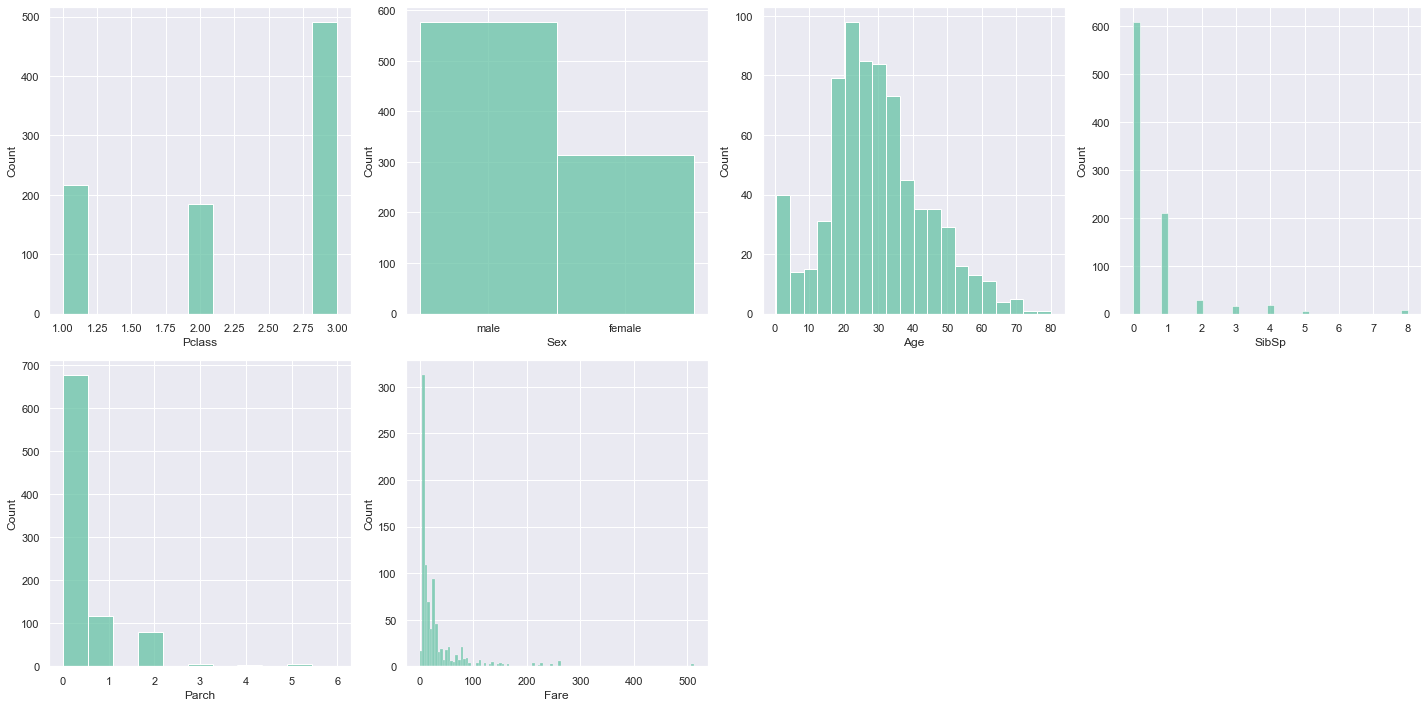

In [17]:
#定义绘图函数
def plot_mutihist(num_row,num_col,hist_columns):
    #组图，分为几行几列
    f,axs = plt.subplots(num_row,num_col,squeeze=True,figsize=(20,10))
    #移除没有用到的图框
    for i in range(len(hist_columns)%num_col,num_col):
        axs[num_row-1,i].remove()
    for i in range(len(hist_columns)):
        sns.histplot(data=titanic_train,x=hist_columns[i],ax=axs[i//num_col,i%num_col])
    f.tight_layout()
titanic_hist_columns=['Pclass','Sex','Age','SibSp','Parch','Fare']
plot_mutihist(num_row=2,num_col=4,hist_columns=titanic_hist_columns)

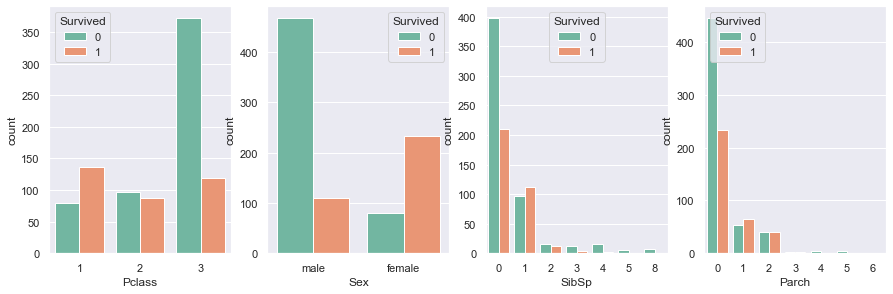

In [19]:
def plot_countplot_hue(num_row,num_col,count_columns):
    f,axs=plt.subplots(num_row,num_col,squeeze=True,figsize=(15,10))
    for i in range(len(count_columns)%num_col,num_col):
        axs[num_row-1,i].remove()
    for i in range(len(count_columns)):
        sns.countplot(data=titanic_train,x=count_columns[i],hue='Survived',ax=axs[i//num_col,i%num_col])

titanic_count_columns=['Pclass','Sex','SibSp','Parch']
plot_countplot_hue(num_row=2,num_col=4,count_columns=titanic_count_columns)

<AxesSubplot:>

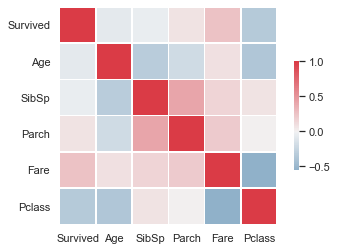

In [20]:
titanic_heatmap_columns=['Survived','Age','SibSp','Parch','Fare','Pclass']
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(titanic_train[titanic_heatmap_columns].corr(), cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


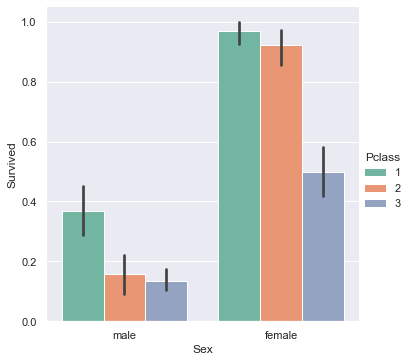

In [21]:
#特征分析
#性别、票的级别与是否幸存的关系
sns.catplot(x='Sex',y='Survived',kind='bar',hue='Pclass',data=titanic_train)


<AxesSubplot:xlabel='Family_group', ylabel='Survived'>

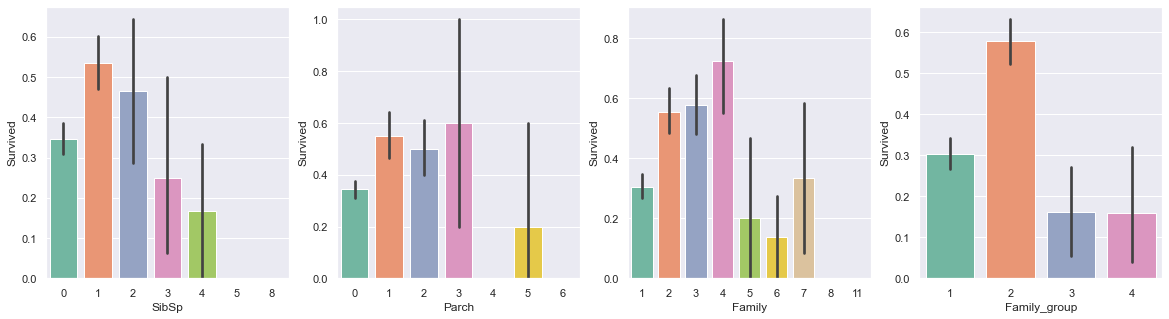

In [22]:
f,axs=plt.subplots(1,4,squeeze=True,figsize=(20,5))
sns.barplot(x='SibSp',y='Survived',data=titanic_train,ax=axs[0])
sns.barplot(x='Parch',y='Survived',data=titanic_train,ax=axs[1])

titanic_train['Family']=titanic_train['SibSp']+titanic_train['Parch']+1
sns.barplot(x='Family',y='Survived',data=titanic_train,ax=axs[2])
def groupfamily(x):
    if x==1:
        return 1
    elif (2<=x)&(x<=4):
        return 2
    elif (5<=x)&(x<=6):
        return 3
    else:
        return 4
titanic_train['Family_group']=titanic_train['Family'].apply(groupfamily)

sns.barplot(x='Family_group',y='Survived',data=titanic_train,ax=axs[3])

